In [ ]:
import shap
import xgboost as xgb
import pandas as pd
import numpy as np

In [ ]:
def get_features(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month
    df['emissions_7d_avg'] = df['emissions'].rolling(window=7, min_periods=1).mean()
    df['emission_intensity'] = df['emissions'] / df['production']
    

    df['timestamp'] = df['timestamp'].dt.strftime('%d-%m-%Y')
    return df

In [31]:
dates = pd.date_range(start='01-01-2025', periods=30)
df = pd.DataFrame({
    'timestamp': dates,
    'emissions': np.random.randint(80, 120, size=30),
    'production': np.random.randint(40, 70, size=30)
})
df['target'] = df['emissions'] * 0.7 + np.random.normal(0, 5, size=30)

df_feat = get_features(df)

X = df_feat.drop(columns=['timestamp', 'target'])
y = df_feat['target']

df_feat.head()


,timestamp,emissions,production,target,day_of_week,month,emissions_7d_avg,emission_intensity
0,01-01-2025,108,40,73.617992,2,1,108.000000,2.700000
1,02-01-2025,118,45,70.592197,3,1,113.000000,2.622222
2,03-01-2025,108,69,70.082464,4,1,111.333333,1.565217
3,04-01-2025,104,42,75.092285,5,1,109.500000,2.476190
4,05-01-2025,113,66,81.913421,6,1,110.200000,1.712121


In [8]:
model = xgb.XGBRegressor()
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

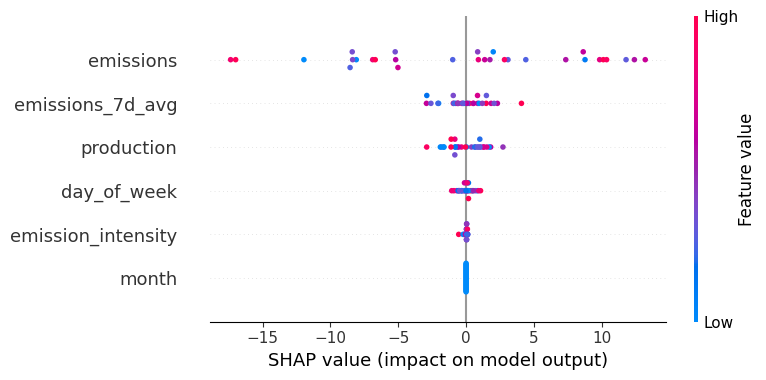

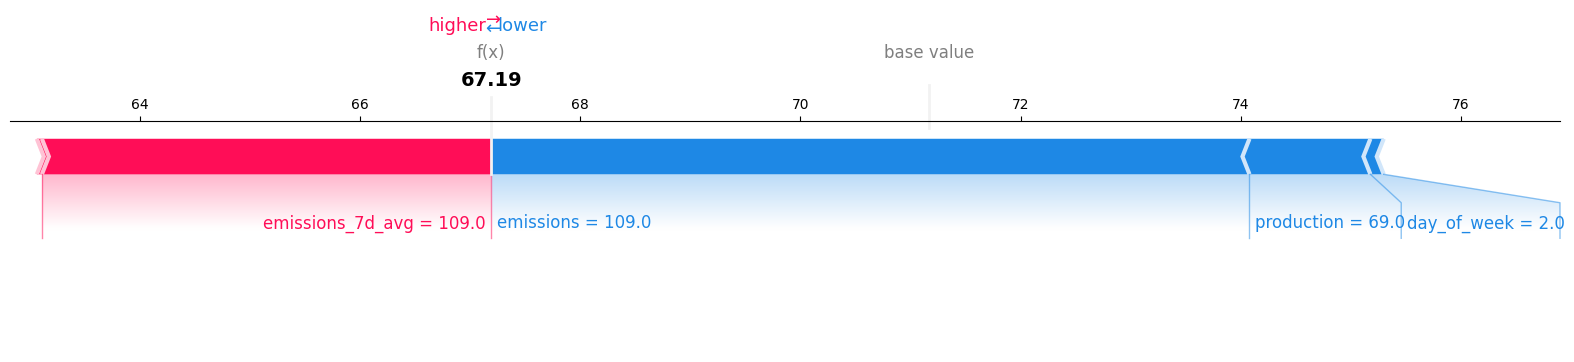

In [ ]:
shap.summary_plot(shap_values, X)
i = 0 #this index is the row we are explaining (in this case it is the first row in the dataframe)
force_plot = shap.force_plot(explainer.expected_value, shap_values[i].values, X.iloc[i], matplotlib=True)

# To save to HTML for audit reports, we need to set matplotlib to Flase and uncomment the line below
# shap.save_html("shap_audit_1.html", force_plot)

## we start at the base value (which is the average of prediction of all rows) then each feature influence the predictions. Either it makes it higher or lower. The width of each bar represents the importance of each feature so this means the widest is the most impactful feature on the prediction, in this case its the emission feature